In [25]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import copy
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets
from matplotlib.pyplot import imshow
from sklearn.metrics import f1_score
from torch.optim import SGD, Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [26]:
transform = transforms.Compose(
    [
        transforms.Resize(size=(180, 180)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dir = "../data/train"  # path to the train folder
validation_dir = "../data/validation"  # path to the validation folder
test_dir = "../data/test"  # path to test folder

train_data = datasets.ImageFolder(root=train_dir, transform=transform)

validation_data = datasets.ImageFolder(root=validation_dir, transform=transform)

test_data = datasets.ImageFolder(root=test_dir, transform=transform)

print(
    f"Train data:\n{train_data}\n\nValidation data:\n{validation_data}\n\nTest data:\n{test_data}"
)

data_loaders = {
    "train": DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2),
    "validation": DataLoader(
        validation_data, batch_size=4, shuffle=True, num_workers=2
    ),
}

Train data:
Dataset ImageFolder
    Number of datapoints: 3689
    Root location: ../data/train
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Validation data:
Dataset ImageFolder
    Number of datapoints: 495
    Root location: ../data/validation
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Test data:
Dataset ImageFolder
    Number of datapoints: 494
    Root location: ../data/test
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5,

In [27]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, dropout=0.4):  # Dodaj parametr dropout
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 22 * 22, 256)
        self.act4 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)  # Ustawienie dropout z parametru
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.pool1(self.act1(self.bn1(self.conv1(x))))
        out = self.pool2(self.act2(self.bn2(self.conv2(out))))
        out = self.pool3(self.act3(self.bn3(self.conv3(out))))
        out = out.view(out.size(0), -1)
        out = self.act4(self.fc1(out))
        out = self.dropout(out)  # Użycie dropout
        out = self.fc2(out)
        return out

model = SimpleCNN().to(device)

In [28]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss, correct = 0, 0
    size = len(dataloader.dataset)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    accuracy = 100 * correct / size
    return train_loss / len(dataloader), accuracy


def validate(dataloader, model, loss_fn):
    model.eval()
    validation_loss, correct = 0, 0
    size = len(dataloader.dataset)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    accuracy = 100 * correct / size
    return validation_loss / len(dataloader), accuracy

In [29]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
loss_fn = nn.CrossEntropyLoss()
epochs = 20

In [30]:
results = {
    "dropout": [],
    "train_acc": [],
    "validation_acc": [],
    "train_loss": [],
    "validation_loss": [],
}

for dropout in dropout_rates:

    print(f"Training with dropout rate: {dropout}")


    model = SimpleCNN(dropout=dropout).to(device)

    optimizer = optim.SGD(model.parameters(), lr=1e-3)  # Stała wartość learning rate

    train_accuracies = []
    validation_accuracies = []

    train_losses = []
    validation_losses = []

    for epoch in range(epochs):


        print(f"Epoch {epoch+1}/{epochs}")

        train_loss, train_acc = train(data_loaders["train"], model, loss_fn, optimizer)

        val_loss, val_acc = validate(data_loaders["validation"], model, loss_fn)

        train_accuracies.append(train_acc)
        validation_accuracies.append(val_acc)
        train_losses.append(train_loss)
        validation_losses.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")


    results["dropout"].append(dropout)
    results["train_acc"].append(train_accuracies[-1]) 
    results["validation_acc"].append(validation_accuracies[-1])
    results["train_loss"].append(train_losses[-1])
    results["validation_loss"].append(validation_losses[-1])

Training with dropout rate: 0.0
Epoch 1/20
Train Loss: 0.6033, Validation Loss: 0.5677
Train Accuracy: 70.07%, Validation Accuracy: 69.90%
Epoch 2/20
Train Loss: 0.5248, Validation Loss: 0.4686
Train Accuracy: 73.57%, Validation Accuracy: 74.55%
Epoch 3/20
Train Loss: 0.3981, Validation Loss: 0.3991
Train Accuracy: 81.78%, Validation Accuracy: 79.60%
Epoch 4/20
Train Loss: 0.2829, Validation Loss: 0.5187
Train Accuracy: 87.75%, Validation Accuracy: 78.59%
Epoch 5/20
Train Loss: 0.2131, Validation Loss: 0.2686
Train Accuracy: 91.65%, Validation Accuracy: 89.29%
Epoch 6/20
Train Loss: 0.1681, Validation Loss: 0.6330
Train Accuracy: 92.76%, Validation Accuracy: 78.18%
Epoch 7/20
Train Loss: 0.1357, Validation Loss: 3.7386
Train Accuracy: 94.63%, Validation Accuracy: 30.91%
Epoch 8/20
Train Loss: 0.1123, Validation Loss: 0.2222
Train Accuracy: 95.99%, Validation Accuracy: 91.72%
Epoch 9/20
Train Loss: 0.0793, Validation Loss: 0.2831
Train Accuracy: 97.53%, Validation Accuracy: 89.09%
Epoch

In [31]:
import json

with open("./results/dropout_1.json", "w") as file:
    json.dump(results, file, indent=4)

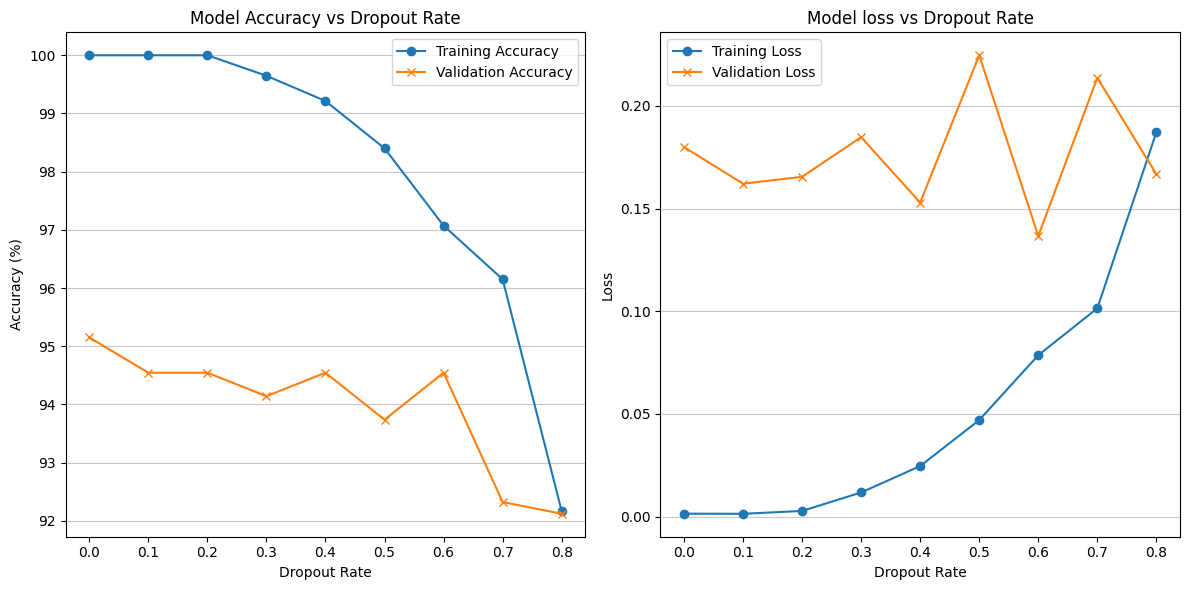

In [44]:
# Wizualizacja wyników
plt.figure(figsize=(12, 6))

# Train accuracy vs Dropout rate
plt.subplot(1, 2, 1)
plt.plot(results["dropout"], results["train_acc"], label="Training Accuracy",marker="o")
plt.plot(results["dropout"], results["validation_acc"], label="Validation Accuracy",marker="x")
plt.title("Model Accuracy vs Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Accuracy (%)")
plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.legend()

# Validation accuracy vs Dropout rate
plt.subplot(1, 2, 2)
plt.plot(results["dropout"], results["train_loss"], label="Training Loss",marker="o")
plt.plot(results["dropout"], results["validation_loss"], label="Validation Loss",marker="x")
plt.title("Model loss vs Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Loss")
plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

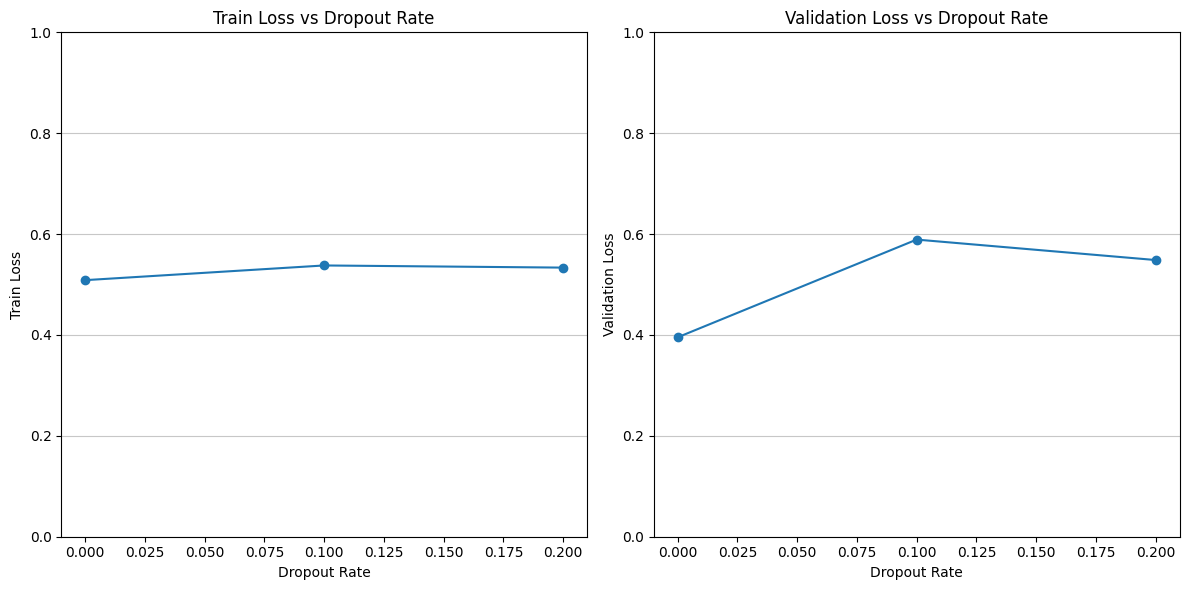

In [17]:
# Wizualizacja wyników
plt.figure(figsize=(12, 6))

# Train accuracy vs Dropout rate
plt.subplot(1, 2, 1)
plt.plot(results["dropout"], results["train_loss"], marker="o")
plt.title("Train Loss vs Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Train Loss")
plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.ylim(0, 1)

# Validation accuracy vs Dropout rate
plt.subplot(1, 2, 2)
plt.plot(results["dropout"], results["validation_loss"], marker="o")
plt.title("Validation Loss vs Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Validation Loss")
plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()